In [1]:
import numpy as np
import gym
import math

from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from pprint import pprint

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class Observation:
    def __init__(self, state_hash, board, actions, cur_turn):
        self.hash = state_hash
        self.board = board
        self.actions = actions
        self.cur_turn = cur_turn
    
    def __repr__(self):
        return f'hash: {self.hash},\n board:\n {self.board},\n actions:{self.actions},\n turn:{self.cur_turn}'


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        self.empty_spaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def get_empty_spaces(self):
        if self.empty_spaces is None:
            res = np.where(self.board == 0)
            self.empty_spaces = np.array([ self.int_from_action((i, j)) for i,j in zip(res[0], res[1])])
        return self.empty_spaces
        
    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.empty_spaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self) -> Observation:
        return Observation(self.getHash(), self.board, self.get_empty_spaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def _step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10 * self.curTurn, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}
    
    def step(self, num):
        state, reward, done, info = self._step(self.action_from_int(num))        
        return state, reward, done, info

    def reset(self)-> Observation:
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.empty_spaces = None
        self.curTurn = 1
        return self.getState()


In [3]:
class BaseAgent:
    def __init__(self, env: TicTacToe):
        self.env = env
        self.actions_count = env.n_rows * env.n_cols
    
    def learn(self, state, action, reward, new_state):
        pass
    
    def get_action(self, state: Observation, eps=0.01):
        pass

In [4]:
def plot_result(data, title): 
    plt.figure(figsize=(10,8))
    plt.plot(
        data[0],
        data[2],
        label='X'
    )

    plt.plot(
        data[0],
        data[3],
        label='O'
    )

    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg reward')
    plt.title(title)
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.plot(
        data[0],
        data[1]
    )
    plt.xlabel('Episodes')
    plt.ylabel('Avg reward')
    plt.title('2 greedy stratages')
    plt.grid()
    plt.show()

### Часть первая: крестики-нолики при помощи Q-обучения
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [ ]:
class QLearning(BaseAgent):
    def __init__(self, env, alpha=0.1, gamma=0.85):
        super().__init__(env)
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}
    
    def learn(self, state: Observation, action, reward, new_state: Observation):
        if state.hash not in self.Q:
            self.Q[state.hash] = np.random.random(size=self.actions_count)
        if new_state.hash not in self.Q:
            self.Q[new_state.hash] = np.zeros(shape=self.actions_count)
        Q = self.Q[state.hash][action]
        Qmax = np.max(self.Q[new_state.hash][state.actions])
        self.Q[state.hash][action] += self.alpha * (reward + self.gamma * Qmax - Q)
    
    def get_action(self, state: Observation, eps=0.0):
        if np.random.random() > eps:
            if state.hash not in self.Q:
                self.Q[state.hash] = np.zeros(shape=self.actions_count)
            return state.actions[np.argmax(self.Q[state.hash][state.actions])]
        return state.actions[np.random.randint(0, len(state.actions))]

In [11]:
class RandomAgent(BaseAgent):
    def get_action(self, state, eps=0):
        return state.actions[np.random.randint(0, len(state.actions))]

In [9]:
class TicTacToeSupervisor:
    def __init__(self, env: TicTacToe, agent1: BaseAgent, agent2: BaseAgent, agent3: BaseAgent):
        self.agent1 = agent1
        self.agent2 = agent2
        self.agent3 = agent3
        self.env = env
        self.eps_init = 0.9
        self.eps_final = 0.05
        self.eps_decay = 200

    def current_eps(self, num_step):
        return self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * num_step / self.eps_decay)
    
    def run_episode(self, cross, nought, eps=0.1):
        done = False
        prevc_state = self.env.reset()
        cross_action = cross.get_action(prevc_state, eps)
        prevn_state, reward, done, _ = self.env.step(cross_action)
        while True:
            nought_action = nought.get_action(prevn_state, eps)
            curc_state, reward, done, _ = self.env.step(nought_action)
            cross.learn(prevc_state, cross_action, reward, curc_state)
            if done:
                nought.learn(prevn_state, nought_action, -reward, curc_state)
                break
            prevc_state = curc_state
            cross_action = cross.get_action(prevc_state, eps)
            curn_state, reward, done, _ = self.env.step(cross_action)
            nought.learn(prevn_state, nought_action, -reward, curn_state)
            if done:
                cross.learn(prevc_state, cross_action, reward, curn_state)
                break
            prevn_state = curn_state
    
    def evaluate(self, crosses: BaseAgent, noughts: BaseAgent, eps=0.0):
        done = False
        state = self.env.reset()
        while not done:
            state, reward, done, _ = self.env.step(crosses.get_action(state, eps))
            if done:
                break
            state, reward, done, _ = self.env.step(noughts.get_action(state, eps))
        
        return reward
    
    def fit(self, episodes, experiments, every, verbose=False):
        x = np.arange(0, episodes, every)
        scores = [np.zeros((episodes + every - 1) // every) for i in range(3)]
        measure_count = 0
        
        for i in tqdm(range(episodes)):
            eps = self.current_eps(i)
            if i % 5 == 0:
                self.run_episode(self.agent1, self.agent2, self.current_eps(i))
            else:
                self.run_episode(self.agent1, self.agent3, eps)
                self.run_episode(self.agent3, self.agent2, eps)

            if every > 0 and i % every == 0:
                for j in range(experiments):
                    scores[1][measure_count] += self.evaluate(self.agent1, self.agent3)
                    scores[2][measure_count] -= self.evaluate(self.agent3, self.agent2)
                scores[0][measure_count] += self.evaluate(self.agent1, self.agent2, eps)
                for j in range(1, 3):
                    scores[j][measure_count] /= experiments
                if verbose:
                    print(f'Episode #{i} score: \t{scores[0][measure_count]}, | \t{scores[1][measure_count]}, | \t{scores[2][measure_count]}')
                measure_count += 1
        
        return (x, *scores)

In [ ]:
env = TicTacToe()
superviser = TicTacToeSupervisor(env, QLearning(env, alpha=0.1, gamma=0.85), QLearning(env, alpha=0.1, gamma=0.85), RandomAgent(env))
data = superviser.fit(200000, 100, 2000, False)

100%|██████████| 200000/200000 [03:32<00:00, 942.32it/s] 


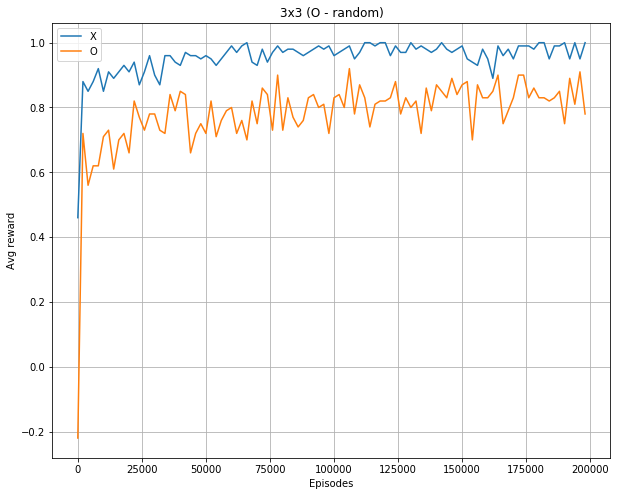

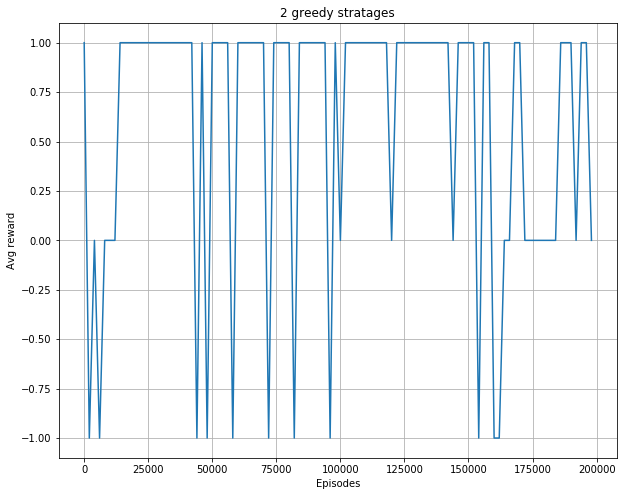

In [ ]:
plot_result(data, '3x3 (O - random)')

In [ ]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
superviser = TicTacToeSupervisor(env, QLearning(env, alpha=0.2, gamma=1), QLearning(env, alpha=0.2, gamma=1), RandomAgent(env))
data = superviser.fit(500000, 50, 20000, False)

100%|██████████| 500000/500000 [18:59<00:00, 438.95it/s]


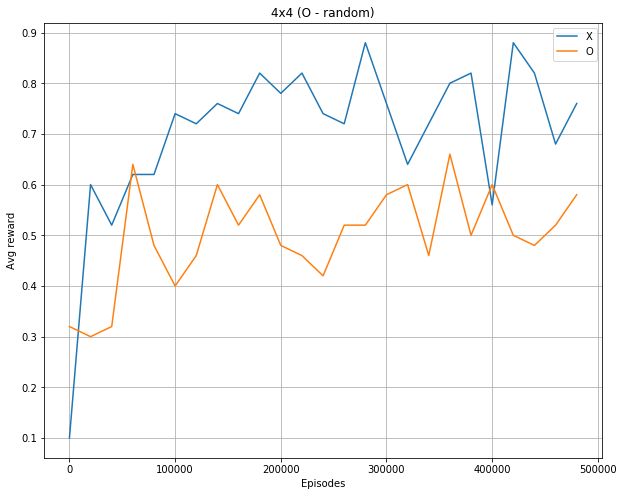

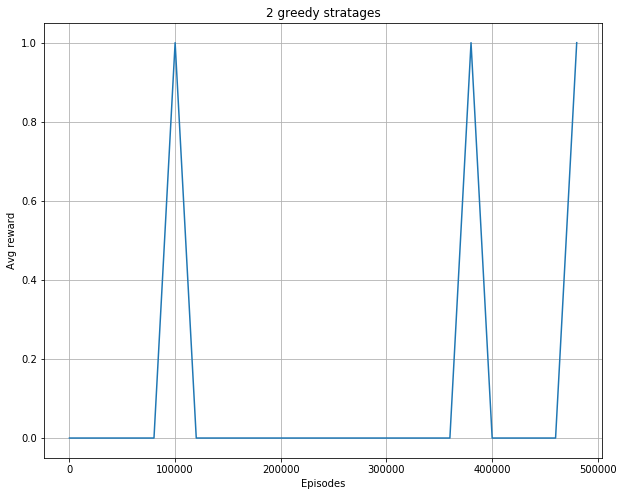

In [ ]:
plot_result(data, '4x4 (O - random)')

### Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

2. Реализуйте Double DQN и/или Dueling DQN.

In [5]:
import random
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class Network(nn.Module):
    def __init__(self, n_rows, n_cols, hidden_size=128):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=(n_rows ,  n_cols))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_rows * n_cols)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Network4(nn.Module):
    def __init__(self, conv1=32, conv2=256):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=conv1, out_channels=conv2, kernel_size=(2, 2))
        self.fc1 = nn.Linear(conv2, conv2)
        self.fc2 = nn.Linear(conv2, 16)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [7]:
class DQN(BaseAgent):
    def __init__(self, env, network, replay_memory, gamma=1):
        super().__init__(env)
        self.model = network
        self.memory = replay_memory
        self.optimizer = optim.Adam(self.model.parameters(), 1e-6)
        self.batch_size = 128
        self.gamma = gamma
    
    def state_to_tensor(self, state):
        return torch.tensor(np.expand_dims(state.board, axis=(0, 1)), dtype=torch.float32)
    
    def get_action(self, state, eps=0.0):
        if np.random.random() > eps:
            with torch.no_grad():
                tensor_state = self.state_to_tensor(state)
            q = self.model(tensor_state)[0].data.cpu().numpy()
            return state.actions[np.argmax(q[state.actions])]
        return state.actions[np.random.randint(0, len(state.actions))]
    
    
    def learn(self, state, action, reward, new_state):
        transition = (self.state_to_tensor(state), action, self.state_to_tensor(new_state), reward)
        self.memory.store(transition)
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = Variable(torch.cat(batch_next_state))
        
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
env = TicTacToe(3, 3)
c_memory, n_memory = ReplayMemory(100000), ReplayMemory(100000)
c_network, n_network = Network(3, 3, 512), Network(3, 3, 512)
DQNCrosses, DQNNoughts = DQN(env, c_network, c_memory), DQN(env, n_network, n_memory)
supervisor = TicTacToeSupervisor(env, DQNCrosses, DQNNoughts, RandomAgent(env))
data = supervisor.fit(15000, 500, 300, True)

  0%|          | 1/15000 [00:02<10:07:38,  2.43s/it]

Episode #0 score: 	-1.0, | 	0.18, | 	-0.386


  2%|▏         | 303/15000 [00:29<1:16:50,  3.19it/s]

Episode #300 score: 	-1.0, | 	0.598, | 	0.3


  4%|▍         | 603/15000 [00:57<1:07:54,  3.53it/s]

Episode #600 score: 	-1.0, | 	0.668, | 	0.428


  6%|▌         | 903/15000 [01:23<1:05:57,  3.56it/s]

Episode #900 score: 	-1.0, | 	0.854, | 	0.336


  8%|▊         | 1203/15000 [01:50<1:07:09,  3.42it/s]

Episode #1200 score: 	-1.0, | 	0.866, | 	0.4


 10%|█         | 1503/15000 [02:15<1:00:53,  3.69it/s]

Episode #1500 score: 	1.0, | 	0.866, | 	0.356


 12%|█▏        | 1802/15000 [02:40<1:11:45,  3.07it/s]

Episode #1800 score: 	-1.0, | 	0.766, | 	0.398


 14%|█▍        | 2102/15000 [03:05<1:14:40,  2.88it/s]

Episode #2100 score: 	1.0, | 	0.92, | 	0.386


 16%|█▌        | 2402/15000 [03:30<1:15:11,  2.79it/s]

Episode #2400 score: 	1.0, | 	0.9, | 	0.39


 18%|█▊        | 2702/15000 [03:55<1:11:38,  2.86it/s]

Episode #2700 score: 	-1.0, | 	0.956, | 	0.368


 20%|██        | 3003/15000 [04:21<56:09,  3.56it/s]  

Episode #3000 score: 	-1.0, | 	0.904, | 	0.356


 22%|██▏       | 3303/15000 [04:46<52:46,  3.69it/s]  

Episode #3300 score: 	1.0, | 	0.902, | 	0.362


 24%|██▍       | 3603/15000 [05:11<52:30,  3.62it/s]  

Episode #3600 score: 	1.0, | 	0.906, | 	0.298


 26%|██▌       | 3903/15000 [05:37<53:56,  3.43it/s]  

Episode #3900 score: 	0.0, | 	0.77, | 	0.32


 28%|██▊       | 4202/15000 [06:02<1:05:50,  2.73it/s]

Episode #4200 score: 	1.0, | 	0.728, | 	0.41


 30%|███       | 4502/15000 [06:27<1:04:26,  2.71it/s]

Episode #4500 score: 	1.0, | 	0.736, | 	0.39


 32%|███▏      | 4802/15000 [06:52<1:02:02,  2.74it/s]

Episode #4800 score: 	1.0, | 	0.768, | 	0.394


 34%|███▍      | 5102/15000 [07:17<1:00:49,  2.71it/s]

Episode #5100 score: 	1.0, | 	0.774, | 	0.432


 36%|███▌      | 5402/15000 [07:43<57:08,  2.80it/s]

Episode #5400 score: 	1.0, | 	0.864, | 	0.334


 38%|███▊      | 5702/15000 [08:07<55:09,  2.81it/s]

Episode #5700 score: 	1.0, | 	0.942, | 	0.32


 40%|████      | 6002/15000 [08:33<54:54,  2.73it/s]

Episode #6000 score: 	-1.0, | 	0.944, | 	0.406


 42%|████▏     | 6302/15000 [08:59<51:08,  2.83it/s]

Episode #6300 score: 	1.0, | 	0.882, | 	0.372


 44%|████▍     | 6602/15000 [09:24<50:04,  2.79it/s]

Episode #6600 score: 	-1.0, | 	0.926, | 	0.418


 46%|████▌     | 6902/15000 [09:50<47:48,  2.82it/s]

Episode #6900 score: 	-1.0, | 	0.916, | 	0.358


 48%|████▊     | 7202/15000 [10:15<47:01,  2.76it/s]

Episode #7200 score: 	1.0, | 	0.904, | 	0.376


 50%|█████     | 7502/15000 [10:40<45:23,  2.75it/s]

Episode #7500 score: 	1.0, | 	0.73, | 	0.322


 52%|█████▏    | 7802/15000 [11:06<43:27,  2.76it/s]

Episode #7800 score: 	-1.0, | 	0.754, | 	0.392


 54%|█████▍    | 8102/15000 [11:32<42:27,  2.71it/s]

Episode #8100 score: 	-1.0, | 	0.782, | 	0.374


 56%|█████▌    | 8402/15000 [11:58<39:48,  2.76it/s]

Episode #8400 score: 	1.0, | 	0.88, | 	0.434


 58%|█████▊    | 8702/15000 [12:24<37:57,  2.77it/s]

Episode #8700 score: 	-1.0, | 	0.796, | 	0.37


 60%|██████    | 9002/15000 [12:49<35:58,  2.78it/s]

Episode #9000 score: 	1.0, | 	0.912, | 	0.454


 62%|██████▏   | 9302/15000 [13:15<33:52,  2.80it/s]

Episode #9300 score: 	1.0, | 	0.872, | 	0.398


 64%|██████▍   | 9602/15000 [13:40<33:05,  2.72it/s]

Episode #9600 score: 	1.0, | 	0.908, | 	0.42


 66%|██████▌   | 9902/15000 [14:05<30:07,  2.82it/s]

Episode #9900 score: 	-1.0, | 	0.75, | 	0.4


 68%|██████▊   | 10202/15000 [14:31<29:17,  2.73it/s]

Episode #10200 score: 	-1.0, | 	0.754, | 	0.388


 70%|███████   | 10502/15000 [14:57<27:09,  2.76it/s]

Episode #10500 score: 	-1.0, | 	0.902, | 	0.412


 72%|███████▏  | 10802/15000 [15:22<25:42,  2.72it/s]

Episode #10800 score: 	-1.0, | 	0.926, | 	0.366


 74%|███████▍  | 11102/15000 [15:48<24:06,  2.69it/s]

Episode #11100 score: 	-1.0, | 	0.768, | 	0.448


 76%|███████▌  | 11402/15000 [16:14<22:10,  2.70it/s]

Episode #11400 score: 	-1.0, | 	0.762, | 	0.304


 78%|███████▊  | 11702/15000 [16:39<19:44,  2.78it/s]

Episode #11700 score: 	-1.0, | 	0.934, | 	0.356


 80%|████████  | 12002/15000 [17:04<18:03,  2.77it/s]

Episode #12000 score: 	1.0, | 	0.898, | 	0.328


 82%|████████▏ | 12302/15000 [17:29<15:49,  2.84it/s]

Episode #12300 score: 	-1.0, | 	0.926, | 	0.328


 84%|████████▍ | 12602/15000 [17:55<14:42,  2.72it/s]

Episode #12600 score: 	-1.0, | 	0.928, | 	0.348


 86%|████████▌ | 12902/15000 [18:20<12:54,  2.71it/s]

Episode #12900 score: 	-1.0, | 	0.938, | 	0.318


 88%|████████▊ | 13202/15000 [18:45<10:45,  2.79it/s]

Episode #13200 score: 	-1.0, | 	0.888, | 	0.42


 90%|█████████ | 13502/15000 [19:10<09:02,  2.76it/s]

Episode #13500 score: 	-1.0, | 	0.918, | 	0.418


 92%|█████████▏| 13802/15000 [19:35<07:04,  2.82it/s]

Episode #13800 score: 	-1.0, | 	0.924, | 	0.356


 94%|█████████▍| 14102/15000 [20:01<05:21,  2.79it/s]

Episode #14100 score: 	1.0, | 	0.906, | 	0.382


 96%|█████████▌| 14402/15000 [20:26<03:36,  2.76it/s]

Episode #14400 score: 	-1.0, | 	0.898, | 	0.346


 98%|█████████▊| 14702/15000 [20:51<01:45,  2.83it/s]

Episode #14700 score: 	-1.0, | 	0.918, | 	0.37


100%|██████████| 15000/15000 [21:14<00:00, 11.76it/s]


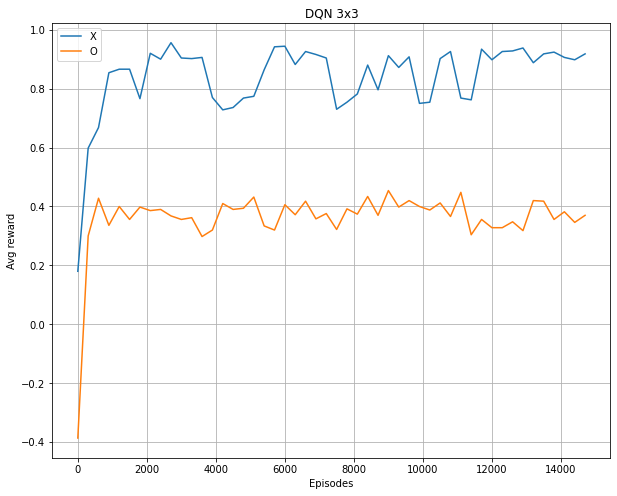

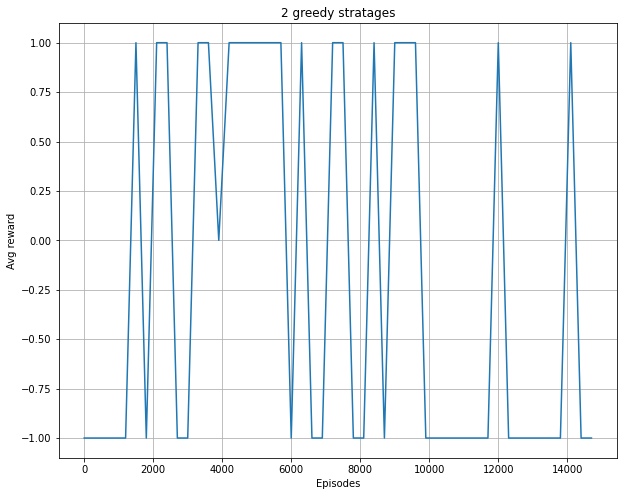

In [13]:
plot_result(data, 'DQN 3x3')

In [14]:
env = TicTacToe(4, 4, 4)
c_memory, n_memory = ReplayMemory(100000), ReplayMemory(100000)
c_network, n_network = Network4(64, 512), Network4(64, 512)
DQNCrosses4, DQNNoughts4 = DQN(env, c_network, c_memory), DQN(env, n_network, n_memory)
supervisor = TicTacToeSupervisor(env, DQNCrosses4, DQNNoughts4, RandomAgent(env))
data = supervisor.fit(10000, 100, 100, True)

  0%|          | 15/10000 [00:01<10:12, 16.31it/s] 

Episode #0 score: 	-1.0, | 	0.26, | 	-0.13


  1%|          | 101/10000 [00:39<2:10:01,  1.27it/s]

Episode #100 score: 	-1.0, | 	0.13, | 	0.07


  2%|▏         | 201/10000 [01:26<2:12:55,  1.23it/s]

Episode #200 score: 	1.0, | 	0.21, | 	-0.06


  3%|▎         | 301/10000 [02:11<2:11:23,  1.23it/s]

Episode #300 score: 	0.0, | 	0.29, | 	0.06


  4%|▍         | 401/10000 [02:57<2:00:26,  1.33it/s]

Episode #400 score: 	-1.0, | 	0.22, | 	0.15


  5%|▌         | 501/10000 [03:42<1:49:55,  1.44it/s]

Episode #500 score: 	1.0, | 	0.48, | 	0.09


  6%|▌         | 601/10000 [04:21<1:44:04,  1.51it/s]

Episode #600 score: 	0.0, | 	0.61, | 	0.26


  7%|▋         | 701/10000 [05:02<1:29:49,  1.73it/s]

Episode #700 score: 	1.0, | 	0.63, | 	0.0


  8%|▊         | 801/10000 [05:40<1:33:05,  1.65it/s]

Episode #800 score: 	1.0, | 	0.63, | 	0.26


  9%|▉         | 901/10000 [06:18<1:44:47,  1.45it/s]

Episode #900 score: 	1.0, | 	0.64, | 	0.18


 10%|█         | 1001/10000 [06:55<1:26:51,  1.73it/s]

Episode #1000 score: 	1.0, | 	0.63, | 	0.41


 11%|█         | 1101/10000 [07:31<1:26:00,  1.72it/s]

Episode #1100 score: 	-1.0, | 	0.62, | 	0.48


 12%|█▏        | 1201/10000 [08:06<1:25:56,  1.71it/s]

Episode #1200 score: 	-1.0, | 	0.68, | 	0.57


 13%|█▎        | 1301/10000 [08:43<1:18:57,  1.84it/s]

Episode #1300 score: 	-1.0, | 	0.64, | 	0.37


 14%|█▍        | 1401/10000 [09:19<1:28:22,  1.62it/s]

Episode #1400 score: 	1.0, | 	0.71, | 	0.5


 15%|█▌        | 1501/10000 [09:54<1:23:27,  1.70it/s]

Episode #1500 score: 	1.0, | 	0.62, | 	0.48


 16%|█▌        | 1601/10000 [10:30<1:30:23,  1.55it/s]

Episode #1600 score: 	-1.0, | 	0.67, | 	0.45


 17%|█▋        | 1701/10000 [11:09<1:27:39,  1.58it/s]

Episode #1700 score: 	1.0, | 	0.75, | 	0.4


 18%|█▊        | 1801/10000 [11:45<1:23:14,  1.64it/s]

Episode #1800 score: 	-1.0, | 	0.72, | 	0.51


 19%|█▉        | 1901/10000 [12:20<1:18:49,  1.71it/s]

Episode #1900 score: 	-1.0, | 	0.63, | 	0.32


 20%|██        | 2001/10000 [12:55<1:17:20,  1.72it/s]

Episode #2000 score: 	-1.0, | 	0.59, | 	0.43


 21%|██        | 2101/10000 [13:31<1:11:59,  1.83it/s]

Episode #2100 score: 	1.0, | 	0.64, | 	0.56


 22%|██▏       | 2201/10000 [14:07<1:13:12,  1.78it/s]

Episode #2200 score: 	1.0, | 	0.61, | 	0.41


 23%|██▎       | 2301/10000 [14:41<1:08:27,  1.87it/s]

Episode #2300 score: 	1.0, | 	0.62, | 	0.42


 24%|██▍       | 2401/10000 [15:16<1:11:54,  1.76it/s]

Episode #2400 score: 	1.0, | 	0.58, | 	0.47


 25%|██▌       | 2501/10000 [15:51<1:13:00,  1.71it/s]

Episode #2500 score: 	0.0, | 	0.42, | 	0.39


 26%|██▌       | 2601/10000 [16:27<1:09:53,  1.76it/s]

Episode #2600 score: 	1.0, | 	0.59, | 	0.49


 27%|██▋       | 2701/10000 [17:01<1:08:01,  1.79it/s]

Episode #2700 score: 	1.0, | 	0.61, | 	0.54


 28%|██▊       | 2801/10000 [17:38<1:04:41,  1.85it/s]

Episode #2800 score: 	1.0, | 	0.47, | 	0.43


 29%|██▉       | 2901/10000 [18:14<1:10:39,  1.67it/s]

Episode #2900 score: 	0.0, | 	0.41, | 	0.42


 30%|███       | 3001/10000 [18:49<1:09:27,  1.68it/s]

Episode #3000 score: 	-1.0, | 	0.61, | 	0.59


 31%|███       | 3101/10000 [19:25<1:05:52,  1.75it/s]

Episode #3100 score: 	1.0, | 	0.55, | 	0.54


 32%|███▏      | 3201/10000 [20:00<1:06:41,  1.70it/s]

Episode #3200 score: 	-1.0, | 	0.52, | 	0.51


 33%|███▎      | 3301/10000 [20:35<1:06:05,  1.69it/s]

Episode #3300 score: 	-1.0, | 	0.74, | 	0.51


 34%|███▍      | 3401/10000 [21:11<1:06:30,  1.65it/s]

Episode #3400 score: 	-1.0, | 	0.59, | 	0.35


 35%|███▌      | 3501/10000 [21:46<1:09:04,  1.57it/s]

Episode #3500 score: 	1.0, | 	0.53, | 	0.47


 36%|███▌      | 3601/10000 [22:21<1:02:23,  1.71it/s]

Episode #3600 score: 	-1.0, | 	0.49, | 	0.35


 37%|███▋      | 3701/10000 [22:57<1:01:18,  1.71it/s]

Episode #3700 score: 	1.0, | 	0.55, | 	0.33


 38%|███▊      | 3801/10000 [23:31<1:02:05,  1.66it/s]

Episode #3800 score: 	-1.0, | 	0.4, | 	0.42


 39%|███▉      | 3901/10000 [24:08<58:18,  1.74it/s]

Episode #3900 score: 	-1.0, | 	0.51, | 	0.47


 40%|████      | 4001/10000 [24:41<55:27,  1.80it/s]

Episode #4000 score: 	1.0, | 	0.61, | 	0.58


 41%|████      | 4101/10000 [25:16<57:19,  1.72it/s]

Episode #4100 score: 	-1.0, | 	0.53, | 	0.57


 42%|████▏     | 4201/10000 [25:51<53:55,  1.79it/s]

Episode #4200 score: 	1.0, | 	0.49, | 	0.59


 43%|████▎     | 4301/10000 [26:25<50:22,  1.89it/s]

Episode #4300 score: 	-1.0, | 	0.63, | 	0.52


 44%|████▍     | 4401/10000 [27:01<50:55,  1.83it/s]

Episode #4400 score: 	-1.0, | 	0.54, | 	0.56


 45%|████▌     | 4501/10000 [27:36<51:40,  1.77it/s]

Episode #4500 score: 	-1.0, | 	0.6, | 	0.4


 46%|████▌     | 4601/10000 [28:11<51:53,  1.73it/s]

Episode #4600 score: 	1.0, | 	0.45, | 	0.33


 47%|████▋     | 4701/10000 [28:47<53:23,  1.65it/s]

Episode #4700 score: 	-1.0, | 	0.69, | 	0.47


 48%|████▊     | 4801/10000 [29:23<51:49,  1.67it/s]

Episode #4800 score: 	1.0, | 	0.71, | 	0.47


 49%|████▉     | 4901/10000 [29:59<51:35,  1.65it/s]

Episode #4900 score: 	-1.0, | 	0.48, | 	0.5


 50%|█████     | 5001/10000 [30:35<50:55,  1.64it/s]

Episode #5000 score: 	-1.0, | 	0.55, | 	0.59


 51%|█████     | 5101/10000 [31:12<47:53,  1.71it/s]

Episode #5100 score: 	1.0, | 	0.65, | 	0.45


 52%|█████▏    | 5201/10000 [31:49<45:54,  1.74it/s]

Episode #5200 score: 	-1.0, | 	0.64, | 	0.49


 53%|█████▎    | 5301/10000 [32:25<45:36,  1.72it/s]

Episode #5300 score: 	-1.0, | 	0.51, | 	0.42


 54%|█████▍    | 5401/10000 [33:01<45:08,  1.70it/s]

Episode #5400 score: 	-1.0, | 	0.53, | 	0.43


 55%|█████▌    | 5501/10000 [33:36<50:28,  1.49it/s]

Episode #5500 score: 	-1.0, | 	0.49, | 	0.48


 56%|█████▌    | 5601/10000 [34:13<43:00,  1.70it/s]

Episode #5600 score: 	-1.0, | 	0.68, | 	0.42


 57%|█████▋    | 5701/10000 [34:48<42:08,  1.70it/s]

Episode #5700 score: 	-1.0, | 	0.38, | 	0.39


 58%|█████▊    | 5801/10000 [35:24<40:26,  1.73it/s]

Episode #5800 score: 	-1.0, | 	0.5, | 	0.5


 59%|█████▉    | 5901/10000 [35:59<38:03,  1.80it/s]

Episode #5900 score: 	1.0, | 	0.49, | 	0.35


 60%|██████    | 6001/10000 [36:34<39:00,  1.71it/s]

Episode #6000 score: 	0.0, | 	0.5, | 	0.48


 61%|██████    | 6101/10000 [37:11<35:37,  1.82it/s]

Episode #6100 score: 	1.0, | 	0.6, | 	0.55


 62%|██████▏   | 6201/10000 [37:47<43:18,  1.46it/s]

Episode #6200 score: 	-1.0, | 	0.61, | 	0.54


 63%|██████▎   | 6301/10000 [38:23<33:09,  1.86it/s]

Episode #6300 score: 	-1.0, | 	0.48, | 	0.44


 64%|██████▍   | 6401/10000 [38:59<33:48,  1.77it/s]

Episode #6400 score: 	1.0, | 	0.51, | 	0.49


 65%|██████▌   | 6501/10000 [39:34<32:50,  1.78it/s]

Episode #6500 score: 	1.0, | 	0.54, | 	0.39


 66%|██████▌   | 6601/10000 [40:10<30:26,  1.86it/s]

Episode #6600 score: 	-1.0, | 	0.55, | 	0.6


 67%|██████▋   | 6701/10000 [40:46<32:32,  1.69it/s]

Episode #6700 score: 	-1.0, | 	0.53, | 	0.54


 68%|██████▊   | 6801/10000 [41:22<32:02,  1.66it/s]

Episode #6800 score: 	1.0, | 	0.6, | 	0.43


 69%|██████▉   | 6901/10000 [41:58<28:58,  1.78it/s]

Episode #6900 score: 	-1.0, | 	0.6, | 	0.44


 70%|███████   | 7001/10000 [42:33<31:20,  1.59it/s]

Episode #7000 score: 	-1.0, | 	0.6, | 	0.44


 71%|███████   | 7101/10000 [43:09<29:47,  1.62it/s]

Episode #7100 score: 	-1.0, | 	0.4, | 	0.52


 72%|███████▏  | 7201/10000 [43:45<27:06,  1.72it/s]

Episode #7200 score: 	-1.0, | 	0.51, | 	0.68


 73%|███████▎  | 7301/10000 [44:21<26:17,  1.71it/s]

Episode #7300 score: 	0.0, | 	0.6, | 	0.34


 74%|███████▍  | 7401/10000 [44:58<27:53,  1.55it/s]

Episode #7400 score: 	1.0, | 	0.49, | 	0.48


 75%|███████▌  | 7501/10000 [45:36<26:38,  1.56it/s]

Episode #7500 score: 	1.0, | 	0.46, | 	0.43


 76%|███████▌  | 7601/10000 [46:13<24:04,  1.66it/s]

Episode #7600 score: 	0.0, | 	0.51, | 	0.42


 77%|███████▋  | 7701/10000 [46:50<23:05,  1.66it/s]

Episode #7700 score: 	1.0, | 	0.69, | 	0.43


 78%|███████▊  | 7801/10000 [47:26<23:03,  1.59it/s]

Episode #7800 score: 	1.0, | 	0.62, | 	0.52


 79%|███████▉  | 7901/10000 [48:02<20:42,  1.69it/s]

Episode #7900 score: 	-1.0, | 	0.6, | 	0.53


 80%|████████  | 8001/10000 [48:38<19:29,  1.71it/s]

Episode #8000 score: 	1.0, | 	0.62, | 	0.36


 81%|████████  | 8101/10000 [49:14<19:56,  1.59it/s]

Episode #8100 score: 	0.0, | 	0.64, | 	0.47


 82%|████████▏ | 8201/10000 [49:50<17:33,  1.71it/s]

Episode #8200 score: 	1.0, | 	0.5, | 	0.4


 83%|████████▎ | 8301/10000 [50:26<16:47,  1.69it/s]

Episode #8300 score: 	1.0, | 	0.53, | 	0.51


 84%|████████▍ | 8401/10000 [51:02<16:17,  1.64it/s]

Episode #8400 score: 	0.0, | 	0.56, | 	0.55


 85%|████████▌ | 8501/10000 [51:37<13:26,  1.86it/s]

Episode #8500 score: 	1.0, | 	0.53, | 	0.42


 86%|████████▌ | 8601/10000 [52:12<13:11,  1.77it/s]

Episode #8600 score: 	1.0, | 	0.54, | 	0.55


 87%|████████▋ | 8701/10000 [52:47<12:22,  1.75it/s]

Episode #8700 score: 	-1.0, | 	0.53, | 	0.35


 88%|████████▊ | 8801/10000 [53:24<11:24,  1.75it/s]

Episode #8800 score: 	1.0, | 	0.5, | 	0.38


 89%|████████▉ | 8901/10000 [53:59<09:54,  1.85it/s]

Episode #8900 score: 	-1.0, | 	0.41, | 	0.33


 90%|█████████ | 9001/10000 [54:35<10:42,  1.55it/s]

Episode #9000 score: 	-1.0, | 	0.67, | 	0.47


 91%|█████████ | 9101/10000 [55:11<08:14,  1.82it/s]

Episode #9100 score: 	-1.0, | 	0.53, | 	0.47


 92%|█████████▏| 9201/10000 [55:47<07:48,  1.71it/s]

Episode #9200 score: 	1.0, | 	0.59, | 	0.53


 93%|█████████▎| 9301/10000 [56:24<06:37,  1.76it/s]

Episode #9300 score: 	0.0, | 	0.48, | 	0.52


 94%|█████████▍| 9401/10000 [57:01<05:55,  1.68it/s]

Episode #9400 score: 	1.0, | 	0.59, | 	0.32


 95%|█████████▌| 9501/10000 [57:37<04:52,  1.71it/s]

Episode #9500 score: 	-1.0, | 	0.51, | 	0.33


 96%|█████████▌| 9601/10000 [58:15<04:06,  1.62it/s]

Episode #9600 score: 	-1.0, | 	0.58, | 	0.53


 97%|█████████▋| 9701/10000 [58:56<03:46,  1.32it/s]

Episode #9700 score: 	1.0, | 	0.52, | 	0.54


 98%|█████████▊| 9801/10000 [59:37<02:08,  1.55it/s]

Episode #9800 score: 	-1.0, | 	0.48, | 	0.42


 99%|█████████▉| 9901/10000 [1:00:17<01:04,  1.53it/s]

Episode #9900 score: 	-1.0, | 	0.53, | 	0.5


100%|██████████| 10000/10000 [1:00:58<00:00,  2.73it/s]


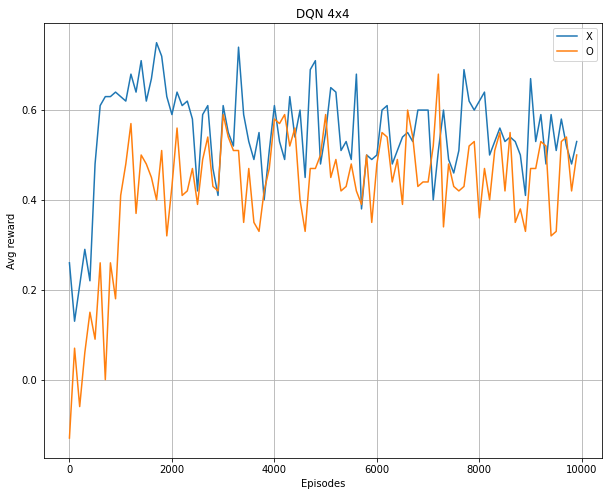

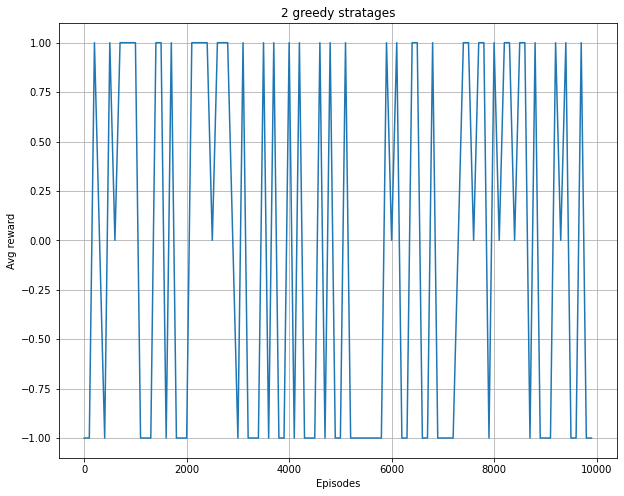

In [15]:
plot_result(data, 'DQN 4x4')

In [17]:
class DoubleDQN(DQN):
    def __init__(self, env, network, support_network, replay_memory, gamma=1):
        super().__init__(env, network, replay_memory)
        self.model = network
        self.support_model = support_network
        self.memory = replay_memory
        self.optimizer = optim.Adam(self.model.parameters(), 1e-6)
        self.batch_size = 128
        self.gamma = gamma
        self.learns = 0
        self.epoch_episodes = 20
    
    def learn(self, state, action, reward, new_state):
        transition = (self.state_to_tensor(state), action, self.state_to_tensor(new_state), reward)
        self.memory.store(transition)
        if len(self.memory) < self.batch_size:
            return
        
        if self.learns == self.epoch_episodes:
            self.support_model.load_state_dict(self.model.state_dict())
            self.learns = 0
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        Qmax = self.model(batch_next_state).detach()[:, torch.argmax(self.support_model(batch_next_state).detach(), 1)][: ,0]
        Qnext = batch_reward + (self.gamma * Qmax)
        
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.learns += 1

In [18]:
env = TicTacToe(3, 3)
c_memory, n_memory = ReplayMemory(100000), ReplayMemory(100000)
c_network, cs_network, n_network, ns_network = Network(3, 3, 512), Network(3, 3, 512), Network(3, 3, 512), Network(3, 3, 512)
DQNCrosses, DQNNoughts = DoubleDQN(env, c_network, cs_network, c_memory), DoubleDQN(env, n_network, ns_network, n_memory)
supervisor = TicTacToeSupervisor(env, DQNCrosses, DQNNoughts, RandomAgent(env))
data = supervisor.fit(6000, 100, 100, True)

  0%|          | 29/6000 [00:00<02:05, 47.41it/s] 

Episode #0 score: 	1.0, | 	0.62, | 	-0.6


  2%|▏         | 102/6000 [00:10<22:50,  4.30it/s]

Episode #100 score: 	0.0, | 	0.63, | 	-0.32


  3%|▎         | 202/6000 [00:23<22:10,  4.36it/s]

Episode #200 score: 	-1.0, | 	0.78, | 	-0.29


  5%|▌         | 301/6000 [00:36<20:12,  4.70it/s]

Episode #300 score: 	0.0, | 	0.93, | 	-0.11


  7%|▋         | 402/6000 [00:49<18:51,  4.95it/s]

Episode #400 score: 	1.0, | 	0.68, | 	0.16


  8%|▊         | 502/6000 [01:01<20:19,  4.51it/s]

Episode #500 score: 	1.0, | 	0.85, | 	0.08


 10%|█         | 602/6000 [01:14<20:36,  4.37it/s]

Episode #600 score: 	1.0, | 	0.72, | 	0.24


 12%|█▏        | 702/6000 [01:26<16:15,  5.43it/s]

Episode #700 score: 	1.0, | 	0.87, | 	0.33


 13%|█▎        | 802/6000 [01:37<17:14,  5.02it/s]

Episode #800 score: 	1.0, | 	0.85, | 	0.3


 15%|█▌        | 903/6000 [01:49<15:20,  5.53it/s]

Episode #900 score: 	-1.0, | 	0.86, | 	0.19


 17%|█▋        | 1002/6000 [02:00<15:43,  5.30it/s]

Episode #1000 score: 	1.0, | 	0.89, | 	0.22


 18%|█▊        | 1102/6000 [02:12<15:30,  5.26it/s]

Episode #1100 score: 	1.0, | 	0.9, | 	0.17


 20%|██        | 1202/6000 [02:24<15:08,  5.28it/s]

Episode #1200 score: 	1.0, | 	0.92, | 	0.14


 22%|██▏       | 1302/6000 [02:35<15:38,  5.00it/s]

Episode #1300 score: 	1.0, | 	0.93, | 	0.28


 23%|██▎       | 1402/6000 [02:46<12:31,  6.11it/s]

Episode #1400 score: 	0.0, | 	0.94, | 	0.26


 25%|██▌       | 1502/6000 [02:57<12:51,  5.83it/s]

Episode #1500 score: 	1.0, | 	0.89, | 	0.12


 27%|██▋       | 1602/6000 [03:08<14:24,  5.09it/s]

Episode #1600 score: 	1.0, | 	0.96, | 	0.12


 28%|██▊       | 1703/6000 [03:20<11:53,  6.02it/s]

Episode #1700 score: 	1.0, | 	0.88, | 	0.14


 30%|███       | 1802/6000 [03:31<12:12,  5.73it/s]

Episode #1800 score: 	1.0, | 	0.88, | 	0.37


 32%|███▏      | 1902/6000 [03:42<12:18,  5.55it/s]

Episode #1900 score: 	1.0, | 	0.81, | 	0.37


 33%|███▎      | 2002/6000 [03:54<13:36,  4.90it/s]

Episode #2000 score: 	-1.0, | 	0.9, | 	0.28


 35%|███▌      | 2102/6000 [04:05<10:21,  6.27it/s]

Episode #2100 score: 	1.0, | 	0.88, | 	0.34


 37%|███▋      | 2202/6000 [04:16<10:52,  5.82it/s]

Episode #2200 score: 	1.0, | 	0.9, | 	0.14


 38%|███▊      | 2303/6000 [04:28<10:05,  6.10it/s]

Episode #2300 score: 	-1.0, | 	0.86, | 	0.26


 40%|████      | 2402/6000 [04:39<11:13,  5.34it/s]

Episode #2400 score: 	-1.0, | 	0.77, | 	0.35


 42%|████▏     | 2502/6000 [04:50<10:53,  5.36it/s]

Episode #2500 score: 	1.0, | 	0.92, | 	0.46


 43%|████▎     | 2602/6000 [05:00<09:06,  6.22it/s]

Episode #2600 score: 	1.0, | 	0.88, | 	0.34


 45%|████▌     | 2702/6000 [05:12<09:20,  5.88it/s]

Episode #2700 score: 	1.0, | 	0.82, | 	0.41


 47%|████▋     | 2802/6000 [05:23<10:04,  5.29it/s]

Episode #2800 score: 	1.0, | 	0.96, | 	0.2


 48%|████▊     | 2903/6000 [05:34<08:04,  6.40it/s]

Episode #2900 score: 	1.0, | 	1.0, | 	0.35


 50%|█████     | 3002/6000 [05:45<08:00,  6.24it/s]

Episode #3000 score: 	1.0, | 	0.88, | 	0.39


 52%|█████▏    | 3102/6000 [05:56<08:27,  5.71it/s]

Episode #3100 score: 	1.0, | 	0.86, | 	0.37


 53%|█████▎    | 3202/6000 [06:07<08:45,  5.32it/s]

Episode #3200 score: 	1.0, | 	0.94, | 	0.55


 55%|█████▌    | 3302/6000 [06:18<07:23,  6.08it/s]

Episode #3300 score: 	1.0, | 	1.0, | 	0.4


 57%|█████▋    | 3402/6000 [06:29<08:02,  5.38it/s]

Episode #3400 score: 	1.0, | 	0.98, | 	0.52


 58%|█████▊    | 3502/6000 [06:40<07:09,  5.81it/s]

Episode #3500 score: 	1.0, | 	0.94, | 	0.58


 60%|██████    | 3603/6000 [06:51<06:26,  6.20it/s]

Episode #3600 score: 	1.0, | 	1.0, | 	0.48


 62%|██████▏   | 3703/6000 [07:02<06:06,  6.27it/s]

Episode #3700 score: 	0.0, | 	0.98, | 	0.28


 63%|██████▎   | 3802/6000 [07:14<07:11,  5.09it/s]

Episode #3800 score: 	1.0, | 	0.96, | 	0.45


 65%|██████▌   | 3902/6000 [07:26<07:07,  4.91it/s]

Episode #3900 score: 	1.0, | 	0.86, | 	0.43


 67%|██████▋   | 4002/6000 [07:37<06:32,  5.09it/s]

Episode #4000 score: 	1.0, | 	0.89, | 	0.38


 68%|██████▊   | 4102/6000 [07:49<06:13,  5.09it/s]

Episode #4100 score: 	1.0, | 	0.96, | 	0.38


 70%|███████   | 4202/6000 [08:01<06:07,  4.89it/s]

Episode #4200 score: 	1.0, | 	0.82, | 	0.28


 72%|███████▏  | 4302/6000 [08:13<05:35,  5.06it/s]

Episode #4300 score: 	1.0, | 	0.85, | 	0.36


 73%|███████▎  | 4402/6000 [08:24<05:45,  4.63it/s]

Episode #4400 score: 	1.0, | 	0.88, | 	0.45


 75%|███████▌  | 4502/6000 [08:36<05:00,  4.98it/s]

Episode #4500 score: 	0.0, | 	0.85, | 	0.5


 77%|███████▋  | 4602/6000 [08:47<04:46,  4.87it/s]

Episode #4600 score: 	1.0, | 	0.88, | 	0.54


 78%|███████▊  | 4702/6000 [08:59<04:25,  4.89it/s]

Episode #4700 score: 	1.0, | 	0.88, | 	0.35


 80%|████████  | 4802/6000 [09:11<03:32,  5.63it/s]

Episode #4800 score: 	1.0, | 	0.92, | 	0.35


 82%|████████▏ | 4902/6000 [09:22<03:30,  5.22it/s]

Episode #4900 score: 	1.0, | 	0.81, | 	0.48


 83%|████████▎ | 5003/6000 [09:34<02:46,  5.99it/s]

Episode #5000 score: 	1.0, | 	0.88, | 	0.46


 85%|████████▌ | 5102/6000 [09:45<02:59,  4.99it/s]

Episode #5100 score: 	1.0, | 	0.87, | 	0.42


 87%|████████▋ | 5202/6000 [09:56<02:22,  5.61it/s]

Episode #5200 score: 	1.0, | 	0.91, | 	0.58


 88%|████████▊ | 5302/6000 [10:08<02:02,  5.70it/s]

Episode #5300 score: 	1.0, | 	0.84, | 	0.46


 90%|█████████ | 5402/6000 [10:19<01:52,  5.29it/s]

Episode #5400 score: 	1.0, | 	0.93, | 	0.61


 92%|█████████▏| 5502/6000 [10:30<01:37,  5.09it/s]

Episode #5500 score: 	1.0, | 	0.9, | 	0.51


 93%|█████████▎| 5602/6000 [10:41<01:11,  5.57it/s]

Episode #5600 score: 	1.0, | 	0.92, | 	0.6


 95%|█████████▌| 5702/6000 [10:52<00:57,  5.15it/s]

Episode #5700 score: 	1.0, | 	0.96, | 	0.6


 97%|█████████▋| 5802/6000 [11:03<00:35,  5.64it/s]

Episode #5800 score: 	1.0, | 	0.87, | 	0.51


 98%|█████████▊| 5901/6000 [11:14<00:21,  4.61it/s]

Episode #5900 score: 	1.0, | 	0.82, | 	0.45


100%|██████████| 6000/6000 [11:24<00:00,  8.76it/s]


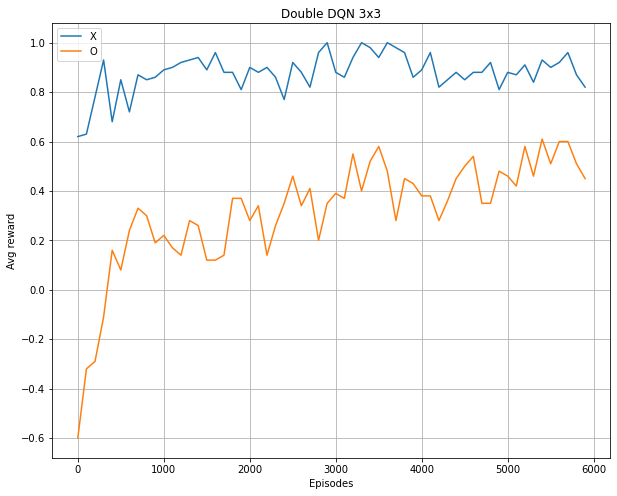

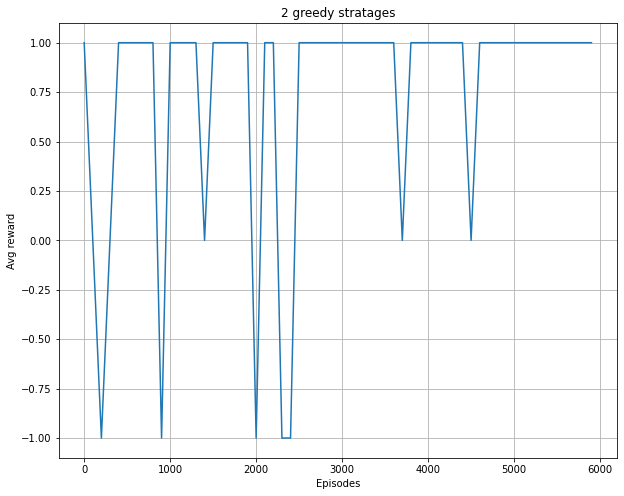

In [19]:
plot_result(data, 'Double DQN 3x3')

In [20]:
env = TicTacToe(4, 4)
c_memory, n_memory = ReplayMemory(100000), ReplayMemory(100000)
c_network, cs_network, n_network, ns_network = Network(4, 4, 512), Network(4, 4, 512), Network(4, 4, 512), Network(4, 4, 512)
DQNCrosses, DQNNoughts = DoubleDQN(env, c_network, cs_network, c_memory), DoubleDQN(env, n_network, ns_network, n_memory)
supervisor = TicTacToeSupervisor(env, DQNCrosses, DQNNoughts, RandomAgent(env))
data = supervisor.fit(6000, 100, 100, True)

  0%|          | 18/6000 [00:01<04:20, 22.99it/s] 

Episode #0 score: 	-1.0, | 	-0.06, | 	-0.4


  2%|▏         | 102/6000 [00:15<34:03,  2.89it/s]

Episode #100 score: 	1.0, | 	0.13, | 	-0.24


  3%|▎         | 202/6000 [00:33<33:10,  2.91it/s]

Episode #200 score: 	1.0, | 	0.6, | 	0.16


  5%|▌         | 302/6000 [00:50<28:54,  3.28it/s]

Episode #300 score: 	1.0, | 	0.7, | 	0.48


  7%|▋         | 402/6000 [01:07<30:03,  3.10it/s]

Episode #400 score: 	-1.0, | 	0.86, | 	0.6


  8%|▊         | 502/6000 [01:23<25:29,  3.59it/s]

Episode #500 score: 	-1.0, | 	0.82, | 	0.54


 10%|█         | 602/6000 [01:39<24:17,  3.70it/s]

Episode #600 score: 	1.0, | 	0.84, | 	0.7


 12%|█▏        | 702/6000 [01:53<23:14,  3.80it/s]

Episode #700 score: 	-1.0, | 	0.82, | 	0.68


 13%|█▎        | 802/6000 [02:07<20:28,  4.23it/s]

Episode #800 score: 	-1.0, | 	0.8, | 	0.7


 15%|█▌        | 901/6000 [02:21<24:01,  3.54it/s]

Episode #900 score: 	1.0, | 	0.94, | 	0.78


 17%|█▋        | 1002/6000 [02:35<22:32,  3.69it/s]

Episode #1000 score: 	-1.0, | 	0.9, | 	0.74


 18%|█▊        | 1102/6000 [02:48<20:59,  3.89it/s]

Episode #1100 score: 	1.0, | 	0.96, | 	0.72


 20%|██        | 1202/6000 [03:02<20:11,  3.96it/s]

Episode #1200 score: 	1.0, | 	0.92, | 	0.66


 22%|██▏       | 1302/6000 [03:15<19:14,  4.07it/s]

Episode #1300 score: 	1.0, | 	0.96, | 	0.86


 23%|██▎       | 1402/6000 [03:29<19:13,  3.99it/s]

Episode #1400 score: 	-1.0, | 	0.96, | 	0.82


 25%|██▌       | 1502/6000 [03:43<18:45,  4.00it/s]

Episode #1500 score: 	-1.0, | 	0.94, | 	0.76


 27%|██▋       | 1602/6000 [03:56<19:03,  3.85it/s]

Episode #1600 score: 	-1.0, | 	0.92, | 	0.74


 28%|██▊       | 1702/6000 [04:10<16:21,  4.38it/s]

Episode #1700 score: 	1.0, | 	0.96, | 	0.72


 30%|███       | 1802/6000 [04:23<17:09,  4.08it/s]

Episode #1800 score: 	1.0, | 	0.94, | 	0.72


 32%|███▏      | 1902/6000 [04:37<16:28,  4.14it/s]

Episode #1900 score: 	1.0, | 	0.96, | 	0.84


 33%|███▎      | 2002/6000 [04:50<15:55,  4.18it/s]

Episode #2000 score: 	-1.0, | 	0.94, | 	0.86


 35%|███▌      | 2102/6000 [05:04<15:13,  4.27it/s]

Episode #2100 score: 	1.0, | 	0.96, | 	0.66


 37%|███▋      | 2202/6000 [05:17<15:41,  4.03it/s]

Episode #2200 score: 	1.0, | 	0.98, | 	0.62


 38%|███▊      | 2302/6000 [05:30<14:07,  4.36it/s]

Episode #2300 score: 	-1.0, | 	1.0, | 	0.7


 40%|████      | 2402/6000 [05:44<14:08,  4.24it/s]

Episode #2400 score: 	1.0, | 	0.96, | 	0.7


 42%|████▏     | 2502/6000 [05:57<13:10,  4.42it/s]

Episode #2500 score: 	1.0, | 	0.88, | 	0.74


 43%|████▎     | 2602/6000 [06:10<13:35,  4.17it/s]

Episode #2600 score: 	1.0, | 	0.96, | 	0.8


 45%|████▌     | 2702/6000 [06:24<13:18,  4.13it/s]

Episode #2700 score: 	1.0, | 	0.96, | 	0.78


 47%|████▋     | 2802/6000 [06:37<12:41,  4.20it/s]

Episode #2800 score: 	1.0, | 	0.94, | 	0.72


 48%|████▊     | 2901/6000 [06:50<15:13,  3.39it/s]

Episode #2900 score: 	1.0, | 	0.92, | 	0.75


 50%|█████     | 3002/6000 [07:03<11:45,  4.25it/s]

Episode #3000 score: 	1.0, | 	0.98, | 	0.8


 52%|█████▏    | 3102/6000 [07:16<10:54,  4.43it/s]

Episode #3100 score: 	1.0, | 	0.96, | 	0.84


 53%|█████▎    | 3202/6000 [07:29<11:01,  4.23it/s]

Episode #3200 score: 	1.0, | 	1.0, | 	0.82


 55%|█████▌    | 3302/6000 [07:41<08:56,  5.03it/s]

Episode #3300 score: 	1.0, | 	0.96, | 	0.8


 57%|█████▋    | 3402/6000 [07:53<10:10,  4.26it/s]

Episode #3400 score: 	1.0, | 	0.9, | 	0.68


 58%|█████▊    | 3502/6000 [08:06<08:57,  4.64it/s]

Episode #3500 score: 	1.0, | 	1.0, | 	0.82


 60%|██████    | 3602/6000 [08:18<08:18,  4.81it/s]

Episode #3600 score: 	1.0, | 	0.94, | 	0.74


 62%|██████▏   | 3702/6000 [08:30<08:38,  4.43it/s]

Episode #3700 score: 	1.0, | 	0.98, | 	0.8


 63%|██████▎   | 3802/6000 [08:43<08:04,  4.54it/s]

Episode #3800 score: 	1.0, | 	1.0, | 	0.78


 65%|██████▌   | 3901/6000 [08:55<09:17,  3.76it/s]

Episode #3900 score: 	1.0, | 	0.98, | 	0.66


 67%|██████▋   | 4002/6000 [09:07<07:24,  4.49it/s]

Episode #4000 score: 	1.0, | 	0.98, | 	0.7


 68%|██████▊   | 4102/6000 [09:20<06:59,  4.53it/s]

Episode #4100 score: 	1.0, | 	0.98, | 	0.8


 70%|███████   | 4202/6000 [09:32<06:42,  4.47it/s]

Episode #4200 score: 	1.0, | 	0.96, | 	0.84


 72%|███████▏  | 4302/6000 [09:44<05:58,  4.74it/s]

Episode #4300 score: 	1.0, | 	1.0, | 	0.76


 73%|███████▎  | 4402/6000 [09:57<06:05,  4.37it/s]

Episode #4400 score: 	1.0, | 	1.0, | 	0.86


 75%|███████▌  | 4502/6000 [10:10<06:01,  4.14it/s]

Episode #4500 score: 	1.0, | 	0.96, | 	0.8


 77%|███████▋  | 4602/6000 [10:23<05:24,  4.30it/s]

Episode #4600 score: 	1.0, | 	1.0, | 	0.86


 78%|███████▊  | 4702/6000 [10:36<05:02,  4.28it/s]

Episode #4700 score: 	1.0, | 	0.96, | 	0.82


 80%|████████  | 4802/6000 [10:49<04:43,  4.22it/s]

Episode #4800 score: 	1.0, | 	1.0, | 	0.88


 82%|████████▏ | 4902/6000 [11:01<04:09,  4.39it/s]

Episode #4900 score: 	1.0, | 	1.0, | 	0.86


 83%|████████▎ | 5002/6000 [11:14<03:39,  4.54it/s]

Episode #5000 score: 	1.0, | 	0.98, | 	0.88


 85%|████████▌ | 5102/6000 [11:26<03:23,  4.41it/s]

Episode #5100 score: 	1.0, | 	1.0, | 	0.84


 87%|████████▋ | 5202/6000 [11:38<02:59,  4.46it/s]

Episode #5200 score: 	1.0, | 	0.96, | 	0.84


 88%|████████▊ | 5302/6000 [11:50<02:25,  4.81it/s]

Episode #5300 score: 	1.0, | 	0.98, | 	0.72


 90%|█████████ | 5402/6000 [12:02<02:03,  4.83it/s]

Episode #5400 score: 	1.0, | 	0.98, | 	0.82


 92%|█████████▏| 5502/6000 [12:14<01:38,  5.07it/s]

Episode #5500 score: 	1.0, | 	1.0, | 	0.9


 93%|█████████▎| 5602/6000 [12:26<01:26,  4.59it/s]

Episode #5600 score: 	1.0, | 	0.98, | 	0.88


 95%|█████████▌| 5702/6000 [12:38<01:00,  4.93it/s]

Episode #5700 score: 	1.0, | 	0.98, | 	0.86


 97%|█████████▋| 5802/6000 [12:50<00:43,  4.58it/s]

Episode #5800 score: 	1.0, | 	1.0, | 	0.8


 98%|█████████▊| 5901/6000 [13:01<00:22,  4.50it/s]

Episode #5900 score: 	1.0, | 	1.0, | 	0.88


100%|██████████| 6000/6000 [13:12<00:00,  7.57it/s]


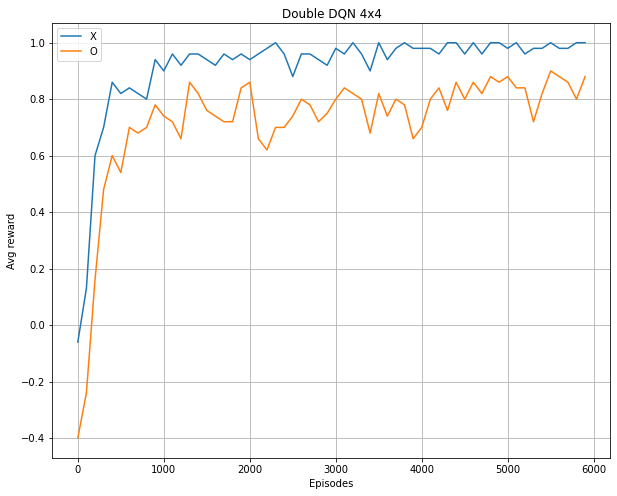

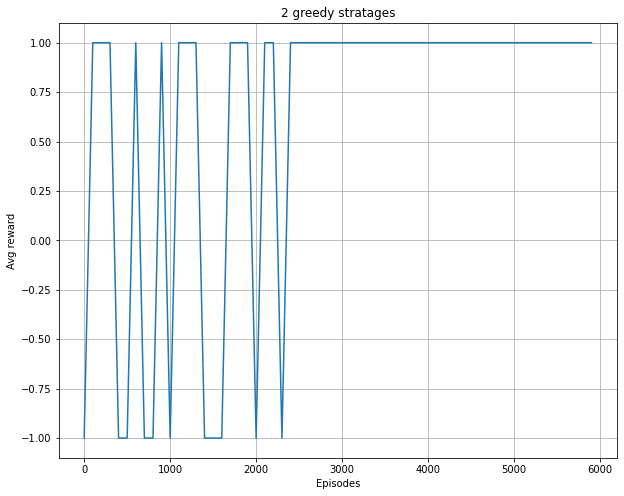

In [21]:
plot_result(data, 'Double DQN 4x4')

### Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

1. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

2. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [22]:
class TreeNode:
    def __init__(self, state, action, turn, parent=None):
        self.state = state
        self.action = action
        self.turn = turn
        self.parent = parent
        self.is_terminal = False
        self.children = []
        self.c_wins = 0
        self.n_wins = 0
        self.visits = 0
        
    def value(self):
        val = self.turn == 1 and self.c_wins or self.n_wins
        return val / self.visits

In [23]:
class MCTS:
    def __init__(self, env: TicTacToe, agent, player, c):
        self.env = env
        self.c = c
        self.agent = agent
        self.player = player
        state = self.env.reset()
        self.root = TreeNode(state.hash, action=None, turn=-1)
        
    def predict_state(self, s, action, player):
        action_str = str(player + 1)
        new_hash = s[:action] + action_str + s[action + 1:]
        return new_hash
    
    def next_child(self, node):
        ucbs = []
        
        val = 0
        best_child = None
        for child in node.children:
            ucb = child.value() + self.c * np.sqrt(np.log(node.visits) / child.visits)
            if ucb >= val or best_child == None:
                best_child = child
                val = ucb
        return best_child
    
    def lift(self, node, c_score, n_score):
        while node is not None:
            node.c_wins += c_score
            node.n_wins += n_score
            node.visits += 1
            node = node.parent
            
    def evaluate(self, player, evals):
        cum_reward = 0
        for _ in range(evals):
            node = self.root
            state = self.env.reset()
            done = False
            turn = 1

            while not done:
                if node.children:
                    if player != turn:
                        child = random.choice(node.children)
                    else:
                        child = max(node.children, key=lambda x: x.value())
                    node = child
                    action = child.action
                else:
                    action = RandomAgent(self.env).get_action(state)
                    
                state, reward, done, _ = self.env.step(action)
                turn *= -1
            cum_reward += reward
        return cum_reward / evals
    
    def set_state_by_hash(self, state_hash, turn):
        self.env.reset()
        size = self.env.n_rows
        board = np.array([int(c) - 1 for c in state_hash]).reshape(size, size)
        self.env.board = board
        self.env.curTurn = turn
        env.empty_spaces = None
        return self.env.getState()
    
    def emulate(self, state, turn):
        state = self.set_state_by_hash(state, turn)
        is_terminal = False
        done = False
        
        if self.env.isTerminal() is not None:
            reward = self.env.isTerminal()
            done = True
            is_terminal = True        
        
        while not done:
            if self.env.curTurn == self.player:
                action = self.agent.get_action(state)
            else:
                action = random.choice(state.actions)
            state, reward, done, _ = self.env.step(action)      
        
        return reward, is_terminal
            
            
    def rollout(self, node):
        if node.is_terminal:
            c_score = int(node.c_wins > 0)
            n_score = int(node.n_wins > 0)
            return c_score, n_score, node.is_terminal
        c_score = 0
        n_score = 0
        
        turn = node.turn * -1
        state = node.state

        reward, is_terminal = self.emulate(state, turn)
        if reward == 1:
            c_score += 1
        if reward == -1:
            n_score += 1
        
        return c_score, n_score, is_terminal
            
    def learn(self):
        cur = self.root
        
        while True:
            if cur.is_terminal:
                c_score, n_score, is_terminal = self.rollout(cur)
                cur.c_wins += c_score
                cur.n_wins += n_score
                cur.is_terminal = is_terminal
                cur.is_new = False
                self.lift(cur, c_score, n_score)
                break
            
            state = self.set_state_by_hash(cur.state, cur.turn)
            actions = set(state.actions)
            child_actions = {child.action for child in cur.children}
            left_actions = list(actions - child_actions)
            
            if left_actions:
                action = random.choice(left_actions)
                new_turn = cur.turn * -1
                new_state = self.predict_state(cur.state, action, new_turn)
                
                child = TreeNode(state=new_state, action=action, turn=new_turn, parent=cur)
                
                cur.children.append(child)
                
                c_score, n_score, is_terminal = self.rollout(child)
                child.c_wins += c_score
                child.n_wins += n_score
                child.is_terminal = is_terminal
                child.is_new = False
                self.lift(child, c_score, n_score)
                
            else:
                if cur.turn == -self.player:
                    child = self.next_child(cur)
                else:
                    child = random.choice(cur.children)
                
            cur = child
            
    def fit(self, iters, every, verbose=False):
        x = []
        rewards = []
        for i in tqdm(range(iters)):
            self.learn()
            if i % every == 0:
                mean_reward = self.evaluate(self.player, evals=500)
                x.append(i)
                rewards.append(mean_reward)
                if verbose:
                    print(f'Episode #{i}, {mean_reward}')
        return (x, rewards)

In [24]:
def plot_mcts(data, title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Avg reward')
    plt.grid(True)
    plt.plot(data[0][0],  np.array(data[0][1]), label='X')
    plt.plot(data[1][0], -np.array(data[1][1]), label='O')
    plt.legend()

In [25]:
env = TicTacToe(3, 3)
c_mcts = MCTS(env, RandomAgent(env), 1, 1.5)
n_mcts = MCTS(env, RandomAgent(env), -1, 1.5)
iters = 30000
every = 100
data = (c_mcts.fit(iters=iters, every=every, verbose=False), n_mcts.fit(iters=iters, every=every))

100%|██████████| 30000/30000 [02:09<00:00, 232.23it/s]


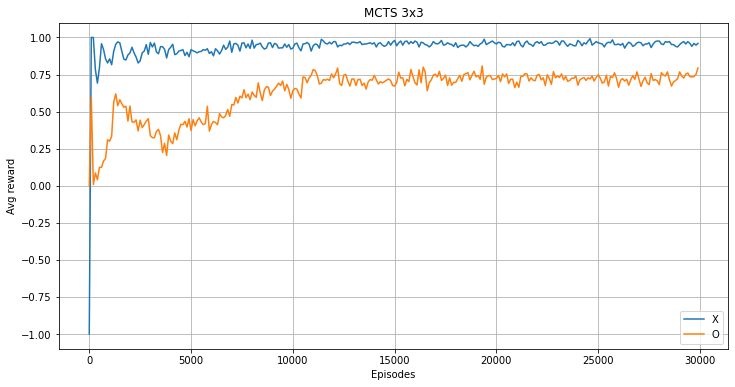

In [26]:
plot_mcts(data, 'MCTS 3x3')

In [27]:
env = TicTacToe(4, 4, 4)
c_mcts = MCTS(env, RandomAgent(env), 1, 1.5)
n_mcts = MCTS(env, RandomAgent(env), -1, 1.5)
iters = 30000
every = 100
data = (c_mcts.fit(iters=iters, every=every, verbose=False), n_mcts.fit(iters=iters, every=every))

100%|██████████| 30000/30000 [10:06<00:00, 49.46it/s]


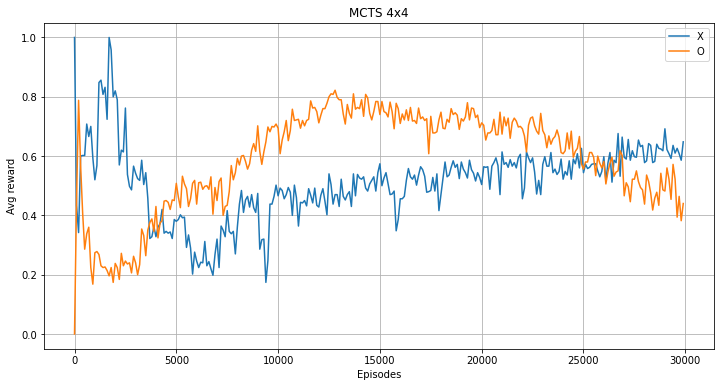

In [28]:
plot_mcts(data, 'MCTS 4x4')